# U-Net | Train Model and Make Submission File

This is a tutorial of [OpenPack Challenge 2022](https://open-pack.github.io/challenge2022/). 
In this notebook, we will build the U-Net, one of the basic architecture for segmentation, with the acceleration data from the left wrist (atr02). This notebook also shows how to make submission file (`submission.json`) for OpenPack Challenge 2022. In fact, the performance of this U-Net is poor. Please enjoy finding a better architecture and parameters.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-pack/openpack-torch/blob/main/examples/unet/notebooks/U-Net_Train-Model-and-Make-Submission-File.ipynb)

**NOTE: When you run this notebook in colab, please change runtime to GPU first.**

## [0] Inital Setup

### 0-1: Download Code and Install `openpack-torch` 
NOTE: You can also install `openpack-torch` from PyPI with `pip install openpack-torch`.

In [ ]:
! cd /content && git clone https://github.com/open-pack/openpack-torch.git

In [ ]:
! cd /content/openpack-torch/ && pip install .

### 0-2: Download Dataset to Your Google Drive
Download OpenPack dataset to your google drive (`/MyDrive/Colab Notebooks/openpack/data`) and make a symlink to `/content/data`. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**NOTE: If you have already downloaded the dataset, you can skip this cell.**

In [ ]:
# NOTE: If you have already downloaded the dataset, you can skip this cell.
! mkdir -p "/content/drive/MyDrive/Colab Notebooks/openpack/data/datasets"
! wget https://raw.githubusercontent.com/open-pack/openpack-toolkit/main/tools/download/dl_from_zenodo.sh
! bash ./dl_from_zenodo.sh "/content/drive/MyDrive/Colab Notebooks/openpack/data/datasets"

In [4]:
! ln -s "/content/drive/MyDrive/Colab Notebooks/openpack/data/" "/content/data"

In [7]:
! ls -la "/content/data/datasets/openpack/v1.0.0"

total 100
drwxrwsr-x 25 1001 240 4096 Nov 19 11:21 .
drwxrwsr-x  3 1001 240 4096 Nov 19 09:56 ..
drwxrwsr-x  7 1001 240 4096 Nov 19 10:06 U0101
drwxrwsr-x  7 1001 240 4096 Nov 19 10:09 U0102
drwxrwsr-x  7 1001 240 4096 Nov 19 10:12 U0103
drwxrwsr-x  7 1001 240 4096 Nov 19 10:16 U0104
drwxrwsr-x  7 1001 240 4096 Nov 19 10:19 U0105
drwxrwsr-x  7 1001 240 4096 Nov 19 10:24 U0106
drwxrwsr-x  7 1001 240 4096 Nov 19 10:28 U0107
drwxrwsr-x  7 1001 240 4096 Nov 19 10:32 U0108
drwxrwsr-x  7 1001 240 4096 Nov 19 10:37 U0109
drwxrwsr-x  7 1001 240 4096 Nov 19 10:41 U0110
drwxrwsr-x  7 1001 240 4096 Nov 19 10:46 U0111
drwxrwsr-x  7 1001 240 4096 Nov 19 10:49 U0201
drwxrwsr-x  7 1001 240 4096 Nov 19 10:53 U0202
drwxrwsr-x  7 1001 240 4096 Nov 19 10:56 U0203
drwxrwsr-x  7 1001 240 4096 Nov 19 11:00 U0204
drwxrwsr-x  7 1001 240 4096 Nov 19 11:05 U0205
drwxrwsr-x  7 1001 240 4096 Nov 19 11:08 U0206
drwxrwsr-x  7 1001 240 4096 Nov 19 11:11 U0207
drwxrwsr-x  7 1001 240 4096 Nov 19 11:14 U0208
drwxrwsr-x

### 0-3: Import Modules

In [68]:
import logging
from logging import getLogger
from pathlib import Path
from typing import Dict, Optional

import hydra
import openpack_toolkit as optk
import pytorch_lightning as pl
import torch
import pandas as pd
import numpy as np
from omegaconf import DictConfig, OmegaConf
from scipy.special import softmax

import matplotlib.pyplot as plt
import seaborn as sns

import openpack_torch as optorch
from openpack_torch.lightning import EarlyStopError
from openpack_torch.utils.test_helper import test_helper

from openpack_toolkit import ActSet
from openpack_toolkit.configs.datasets.annotations import (
    OPENPACK_ACTIONS,
    OPENPACK_OPERATIONS,
)
from openpack_toolkit.codalab.operation_segmentation import (
    construct_submission_dict, eval_operation_segmentation_wrapper,
    make_submission_zipfile)

### 0-4: Setup Logger

In [2]:
_ = optk.utils.notebook.setup_root_logger()
logger = logging.getLogger(__name__)

logger.debug("debug")
logger.info("info")
logger.warning("warning")

2023-11-19 16:05:54 | INFO | __main__ | info
2023-11-19 16:05:54 | WARNING | __main__ | warning


### 0-5: Set Random Seed

In machine learning, a lot of random variables are generated and it affect to model's performance.
By resetting a random seed before each run, you can improve reproducibility. 

In [3]:
optorch.utils.reset_seed(seed=0)

2023-11-19 16:05:54 | INFO | openpack_torch.utils.random | Reset Seeds: python=0, numpy=0, Pytorch (cpu=0, cuda=0)


## [1] Load Config File

### 1-1: Overview of Config Files
Thare are a lot of parameters that are needed to train deep learning models. Managing these parameters is a laborious task.
Here are some useful tools to ease this burden. [hydra](https://hydra.cc/) is a framework for elegantly configurein complex application, and also you can use it to manage parameters.
To update default parameters, please update YAML files in [configs](https://github.com/open-pack/openpack-torch/tree/main/examples/unet/configs).
We will show you some examples here, but when you want to utilse yaml files, please refere to other tutorials.

#### Ex.1: Change Training Parameters

For example, when you want to change default `batch_size`, edit [unet.yaml](https://github.com/open-pack/openpack-torch/blob/main/examples/configs/unet.yaml) as follows.

```yaml
train:
  num_workers: 3
  batch_size: 128 # Updated (original value = 64)
  epochs:
    minimum: 300
    maximum: 1000
```

#### Ex.2: Change Input Modality

An another example is to add IMU sensors at left&right arm (atr03, atr04).
You can change it by editing [atr02-iot.yaml](https://github.com/open-pack/openpack-torch/blob/main/examples/configs/dataset/stream/atr02-iot.yaml)


```yaml
spec:
    imu:
        devices:
        - atr01
        - atr02 # Add
        - atr03 # Add 
        - atr04 # Add
        acc: true
        gyro: false
        quat: false
```

### 1-2: Register Configs to Hydra in `openpack-torch`
First, register OpenPaack official configs to hydra.

In [5]:
optorch.configs.register_configs()

### 1-3: Load Custom Configs
Load configuration files in [/content/openpack-torch/examples/unet/configs](https://github.com/open-pack/openpack-torch/blob/main/examples/unet/configs/operation-segmentation.yaml).
In this notebook, we will copy YAML files to the current directory and load default parameters from there.
You may want to change some default parameters, please save config files into your Google Drive and edit them.
For temporal changes such as learning rate, we can change them by `overrides` param in `hydra.compose()`. 

In [6]:
! cp -r /content/openpack-torch/examples/configs /content/

In [7]:
overrides = [
    "mode=train",
    "metadata.labels.issue=I01-EXP1-V1-nb", # subdirectry for logging
    
    # -- debug --
    # If true, some training parameters (e.g., bach size, epochs) are switched to debug mode setting written in `train.debug.XXX`.
    "debug=true",

    # -- path.logdir.rootdir --
    "path.openpack.version=v1.0.0",
    "path.openpack.rootdir=/content/data/datasets/openpack/${path.openpack.version}/",
    
    # -- path.logdir.rootdir --
    # path to write training logs and resutls.
    # If you want to keep logs, please use Google Drive (i.e., `/content/data/XXX` (symling to Google Drive), `/content/drive/XXX`)
    "path.logdir.rootdir=/content/data/log/${metadata.name}/${metadata.labels.issue}/${metadata.task}/${dataset.split.name}-split/${dataset.stream.name}/${model.name}/${metadata.labels.params}/RUN${run}",
    
    # "hydra/job_logging=custom",
    # "hydra/hydra_logging=disabled"
]

with hydra.initialize_config_dir(version_base=None, config_dir="/content/configs"):
    cfg = hydra.compose(
        config_name="unet.yaml",
        overrides=overrides,
    )

# -- Data Split --
# Change Train/Val/Test/Submission set to submit for Development Phase.
# Please comment out the following block when you want to train on the main set.
cfg.dataset.split = optk.configs.datasets.splits.DEBUG_SPLIT

# (default value)
# cfg.dataset.split = optk.configs.datasets.splits.OPENPACK_CHALLENGE_2022_SPLIT

In [8]:
print(OmegaConf.to_yaml(cfg))

run: 0
debug: true
mode: train
path:
  openpack:
    version: v1.0.0
    rootdir: /content/data/datasets/openpack/${path.openpack.version}/
  datasets:
    openpack: ${path.openpack.rootdir}
  logdir:
    rootdir: /content/data/log/${metadata.name}/${metadata.labels.issue}/${metadata.task}/${dataset.split.name}-split/${dataset.stream.name}/${model.name}/${metadata.labels.params}/RUN${run}
    model: ${path.logdir.rootdir}/model.pth
    predict: ${path.logdir.rootdir}/pred/${train.checkpoint}/{user}-{session}
    summary:
      rootdir: ${path.logdir.rootdir}/summary/${train.checkpoint}
      train: ${.rootdir}/train.csv
      test: ${.rootdir}/test.csv
      test-b2: ${.rootdir}/test-b2.csv
      test-b3: ${.rootdir}/test-b3.csv
      submission: ${.rootdir}/submission.csv
dataset:
  annotation:
    kind: dataset/annotation/csv/sequence
    name: openpack-operations-1hz-annotation
    metadata:
      labels:
        type: annotation/operation
        version: v3.5.0
        dependency:

## [2] Define Utilities (Pytorch Lightning Modules)

### 2-1: DataModule

Define a new DataModule class (e.g., `OpenPackImuDataModule`) and  set [`optorch.data.datasets.OpenPackImu`](https://github.com/open-pack/openpack-torch/blob/main/openpack_torch/data/datasets.py) to `dataset_class`.
When you implement custom dataset, set your dataset class to `dataset_class`.

Paramters to initialize the dataset class should be prepared in `get_kwargs_form_datasets()` method.
The dataset class is initialized with`kwargs`, an output of `get_kwargs_form_datasets()`, as follows. 

```python
# https://github.com/open-pack/openpack-torch/blob/6c6933e24c7c3311e582ebf3aac1a659467be0fb/openpack_torch/data/datamodule.py#L91
self.op_train = self.dataset_class(self.cfg, split.train, **kwargs)
```

In [9]:
class OpenPackImuDataModule(optorch.data.OpenPackBaseDataModule):
    dataset_class = optorch.data.datasets.OpenPackImu

    def get_kwargs_for_datasets(self, stage: Optional[str] = None) -> Dict:
        kwargs = {
            "window": self.cfg.train.window,
            "debug": self.cfg.debug,
        }
        return kwargs

### 2-2: Lightning Module

In the `init_model()` method, you can initialize your model.

In the `init_criterion()` method, you can register your custom loss function.
But make sure that ignore classes are excluded from evaluation process.
For `torch.nn.CrossEntropyLoss`, you can use `ignore_class` parameter.

In [10]:
class UNetLM(optorch.lightning.BaseLightningModule):
    def init_model(self, cfg: DictConfig) -> torch.nn.Module:
        dim = 0
        if self.cfg.dataset.stream.spec.imu.acc:
            dim += 3
        if self.cfg.dataset.stream.spec.imu.gyro:
            dim += 3
        if self.cfg.dataset.stream.spec.imu.quat:
            dim += 4

        input_dim = len(self.cfg.dataset.stream.spec.imu.devices) * dim
        output_dim = len(self.cfg.dataset.annotation.spec.classes)
        model = optorch.models.imu.UNet(
            input_dim,
            output_dim,
            depth=cfg.model.spec.depth,
        )
        return model

    def train_val_common_step(self, batch: Dict, batch_idx: int) -> Dict:
        x = batch["x"].to(device=self.device, dtype=torch.float)
        t = batch["t"].to(device=self.device, dtype=torch.long)
        y_hat = self(x).squeeze(3)

        loss = self.criterion(y_hat, t)
        acc = self.calc_accuracy(y_hat, t)
        return {"loss": loss, "acc": acc}

    def test_step(self, batch: Dict, batch_idx: int) -> Dict:
        x = batch["x"].to(device=self.device, dtype=torch.float)
        t = batch["t"].to(device=self.device, dtype=torch.long)
        ts_unix = batch["ts"]

        y_hat = self(x).squeeze(3)

        outputs = dict(t=t, y=y_hat, unixtime=ts_unix)
        self.test_step_outputs.append(outputs)
        return outputs


## [3] Train U-Net

### 3-1: Initialize U-Net Model and DataLoader.

In [11]:
device = torch.device("cuda")
logdir = Path(cfg.path.logdir.rootdir)
logger.debug(f"logdir = {logdir}")

datamodule = OpenPackImuDataModule(cfg)
plmodel = UNetLM(cfg).to(dtype=torch.float, device=device)

In [12]:
plmodel

UNetLM(
  (net): UNet(
    (inc): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (encoder): UNetEncoder(
      (0): ModuleList(
        (0): DownBlock(
          (double_conv): Sequential(
            (0): Conv2d(32, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
            (3): Conv2d(32, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
            (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (5): ReLU()
          )
          (pool): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
        )
        (1): DownBlock(
          (double_conv): Sequential(
            (0): Conv2d(32, 64, kernel_size=(3, 1), strid

### 3-2: Initialize Trainer

In [13]:
max_epoch = (
    cfg.train.debug.epochs.maximum if cfg.debug else cfg.train.epochs.maximum
)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    save_top_k=1,
    save_last=True,
    mode=cfg.train.early_stop.mode,
    monitor=cfg.train.early_stop.monitor,
    filename="{epoch:02d}-{train/loss:.2f}-{val/loss:.2f}",
    verbose=False,
)

early_stop_callback = pl.callbacks.EarlyStopping(
    **cfg.train.early_stop,
)

pl_logger = pl.loggers.CSVLogger(logdir)
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    min_epochs=1,
    max_epochs=max_epoch,
    logger=pl_logger,
    default_root_dir=logdir,
    enable_progress_bar=True,
    enable_checkpointing=True,
    callbacks=[checkpoint_callback, early_stop_callback],
    log_every_n_steps=4,
)
logger.debug(f"logdir = {logdir}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### 3-3: Start training!

In [14]:
logger.info(f"Start training for {max_epoch} epochs.")
try:
    trainer.fit(plmodel, datamodule)
except EarlyStopError as e:
    logger.warning(e)
logger.info(f"Finish training! (logdir = {logdir})")

2023-11-19 16:09:36 | INFO | __main__ | Start training for 10 epochs.
2023-11-19 16:09:37 | INFO | openpack_torch.data.datamodule | dataset[train]: OpenPackImu(index=129, num_sequence=3, submission=False, random_crop=True)
2023-11-19 16:09:37 | INFO | openpack_torch.data.datamodule | dataset[val]: {'U0102-S0400': <openpack_torch.data.datasets.OpenPackImu object at 0x7f84e7d06800>}
2023-11-19 16:09:37 | INFO | openpack_torch.data.datamodule | dataset[test]: None
2023-11-19 16:09:37 | INFO | openpack_torch.data.datamodule | dataset[submission]: None
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2023-11-19 16:09:37 | INFO | openpack_torch.lightning | Adam optimizer is selected! (lr=0.001)
2023-11-19 16:09:37 | INFO | openpack_torch.lightning | StepLR scheduler is selected.

  | Name      | Type             | Params
-----------------------------------------------
0 | net       | UNet             | 11.5 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------


Epoch 0: 100% 17/17 [00:00<00:00, 31.02it/s, v_num=1]          
Validation: |          | 0/? [00:00<?, ?it/s]
Validation:   0% 0/5 [00:00<?, ?it/s]        
Validation DataLoader 0:   0% 0/5 [00:00<?, ?it/s]
Validation DataLoader 0:  20% 1/5 [00:00<00:00, 90.64it/s]
Validation DataLoader 0:  40% 2/5 [00:00<00:00, 101.92it/s]
Validation DataLoader 0:  60% 3/5 [00:00<00:00, 107.08it/s]
Validation DataLoader 0:  80% 4/5 [00:00<00:00, 106.67it/s]
Validation DataLoader 0: 100% 5/5 [00:00<00:00, 86.87it/s] 
Epoch 1: 100% 17/17 [00:00<00:00, 42.15it/s, v_num=1, val/loss=2.390, val/acc=0.0804, train/loss=2.210, train/acc=0.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation:   0% 0/5 [00:00<?, ?it/s]        
Validation DataLoader 0:   0% 0/5 [00:00<?, ?it/s]
Validation DataLoader 0:  20% 1/5 [00:00<00:00, 99.06it/s]
Validation DataLoader 0:  40% 2/5 [00:00<00:00, 99.02it/s]
Validation DataLoader 0:  60% 3/5 [00:00<00:00, 99.24it/s]
Validation DataLoader 0:  80% 4/5 [00:00<00:00, 104.2

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100% 17/17 [00:00<00:00, 22.50it/s, v_num=1, val/loss=1.610, val/acc=0.446, train/loss=1.630, train/acc=0.421]


2023-11-19 16:09:48 | INFO | __main__ | Finish training! (logdir = /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/debug-split/atr02-iot/UNet/adam-exp/LR0.001/TESTSET-U0101/RUN0)


### 3-4: Plot Training Curve

Training logs are stored in `plmodel.log` (dict). Let's visualize training curves for training and validation set.

In [65]:
pl_logdir = Path(cfg.path.logdir.rootdir, "lightning_logs/")
latest_logdir = list(sorted(pl_logdir.iterdir()))[-1]

df = pd.read_csv(Path(latest_logdir, "metrics.csv"))
df["phase"] = df["train/loss"].apply(lambda x: "val" if np.isnan(x) else "train")
df = df.set_index(["epoch", "phase"])

In [66]:
df.head()

step  val/loss   val/acc  train/acc  train/loss
epoch phase                                                 
0     val      16  2.387506  0.080379        NaN         NaN
      train    16       NaN       NaN   0.269622    2.211719
1     val      33  2.344925  0.180840        NaN         NaN
      train    33       NaN       NaN   0.341669    2.001501
2     val      50  2.127848  0.244246        NaN         NaN

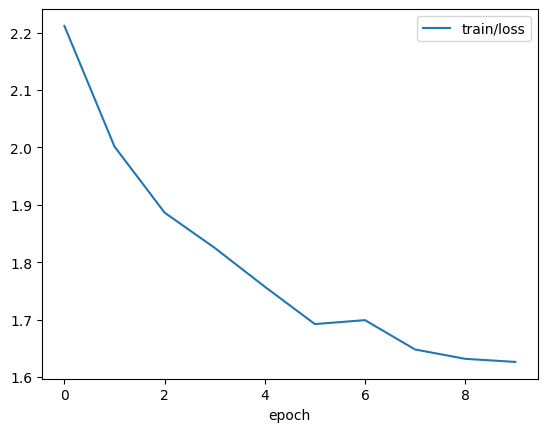

In [67]:
df.xs("train", level="phase")[["train/loss"]].plot()
plt.show()

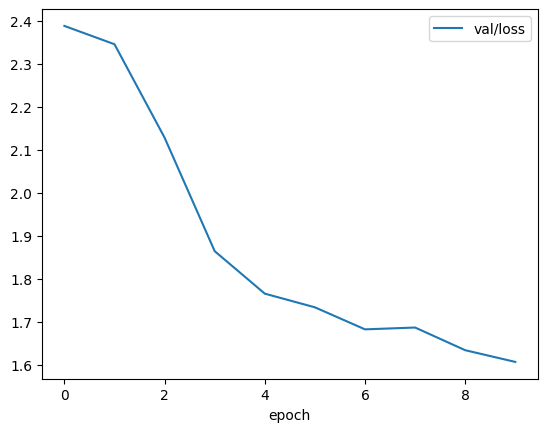

In [40]:
df.xs("val", level="phase")[["val/loss"]].plot()
plt.show()

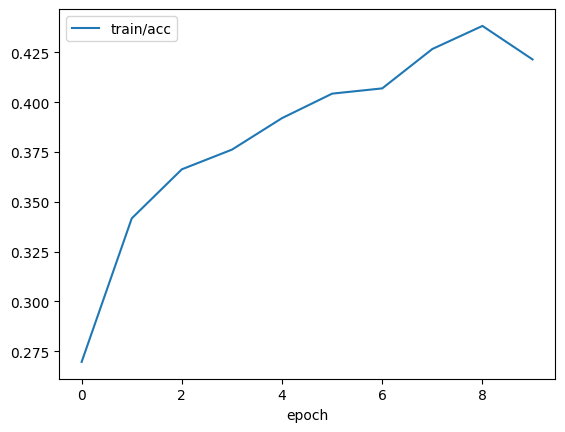

In [41]:
df.xs("train", level="phase")[["train/acc"]].plot()
plt.show()

## [4] Test

Evaluation function is defined in `optk.codalab.eval_operation_segmentation_wrapper()`. This function takes dict as the 2nd argument and prediction (`y`), groundtruth (`t_idx`; activity class index) and corresponding unixtime (`unixtime`) must be included in the dict object. Each sequence should be stored in the different entries with a key `{user}-{session}` (e.g., `U0107-S0100`).

```python
outputs = {
    "U0102-S0100": {
        "t_idx": [0, 0, ...], # groundtruth (class index)
        "y": [
            [
                [0., 0., ...],
                [0., 0., ...],
                [1., 1., ...],
            ],
        ], # prediction. shape=(B,N_CLASSES,T), dtype=float
        "unixtiume": [634885794000, 1634885794200, ...], # unixtime
    },
    "U0102-S0200": {
        "t_idx": [...], 
        "y": [...],
        "unixtiume": [...],
    },
    ...
}
```

### 4-1: Get prediction results for each sequences and build result dict.

NOTE: In `DEBUG_SPLIT`, U0102-S0500 is set to both the test set and the submission set for debugging purpose.

In [43]:
datamodule.setup("test")
dataloaders = datamodule.test_dataloader()
split = cfg.dataset.split.test


outputs = dict()
for i, dataloader in enumerate(dataloaders):
    user, session = split[i]
    logger.info(f"test on {user}-{session}")

    trainer.test(plmodel, dataloader)

    # save model outputs
    pred_dir = Path(
        cfg.path.logdir.predict.format(user=user, session=session)
    )
    pred_dir.mkdir(parents=True, exist_ok=True)

    for key, arr in plmodel.test_results.items():
        path = Path(pred_dir, f"{key}.npy")
        np.save(path, arr)
        logger.info(f"save {key}[shape={arr.shape}] to {path}")

    outputs[f"{user}-{session}"] = {
        "t_idx": plmodel.test_results.get("t"),
        "y": plmodel.test_results.get("y"),
        "unixtime": plmodel.test_results.get("unixtime"),
    }

2023-11-19 16:24:35 | INFO | openpack_torch.data.datamodule | dataset[train]: None
2023-11-19 16:24:35 | INFO | openpack_torch.data.datamodule | dataset[val]: None
2023-11-19 16:24:35 | INFO | openpack_torch.data.datamodule | dataset[test]: {'U0102-S0500': <openpack_torch.data.datasets.OpenPackImu object at 0x7f83ffd22a40>}
2023-11-19 16:24:35 | INFO | openpack_torch.data.datamodule | dataset[submission]: None
2023-11-19 16:24:35 | INFO | __main__ | test on U0102-S0500
2023-11-19 16:24:35 | INFO | openpack_torch.data.datamodule | dataset[train]: None
2023-11-19 16:24:35 | INFO | openpack_torch.data.datamodule | dataset[val]: None
2023-11-19 16:24:35 | INFO | openpack_torch.data.datamodule | dataset[test]: {'U0102-S0500': <openpack_torch.data.datasets.OpenPackImu object at 0x7f84ce1b8610>}
2023-11-19 16:24:35 | INFO | openpack_torch.data.datamodule | dataset[submission]: None
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100% 4/4 [00:00<00:00, 67.24it/s] 

2023-11-19 16:24:35 | INFO | __main__ | save t[shape=(31, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/debug-split/atr02-iot/UNet/adam-exp/LR0.001/TESTSET-U0101/RUN0/pred/last/U0102-S0500/t.npy
2023-11-19 16:24:35 | INFO | __main__ | save y[shape=(31, 11, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/debug-split/atr02-iot/UNet/adam-exp/LR0.001/TESTSET-U0101/RUN0/pred/last/U0102-S0500/y.npy
2023-11-19 16:24:35 | INFO | __main__ | save unixtime[shape=(31, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/debug-split/atr02-iot/UNet/adam-exp/LR0.001/TESTSET-U0101/RUN0/pred/last/U0102-S0500/unixtime.npy


### 4-2: Evaluate

In [47]:
# compute performance summary
df_summary = eval_operation_segmentation_wrapper(
    cfg, outputs, ActSet(OPENPACK_OPERATIONS),
)

2023-11-19 16:25:44 | WARNING | openpack_toolkit.codalab.operation_segmentation.utils | 1 elements are missing from prediction.: [1634887609000]
2023-11-19 16:25:44 | WARNING | openpack_toolkit.codalab.operation_segmentation.utils | fill missing element at ts=1634887609000 (ind=1822) with 100.


In [48]:
df_summary[df_summary["key"]=="all"]

,name,id,precision,recall,f1,support,key
12,avg/macro,-1,0.338489,0.312616,0.295764,None,all
13,avg/weighted,-1,0.353067,0.355285,0.326841,None,all
14,Picking,100,0.289116,0.544872,0.377778,156,all
15,Relocate Item Label,200,0.319853,0.226562,0.265244,384,all
16,Assemble Box,300,0.497354,0.364341,0.420582,258,all
17,Insert Items,400,0.377358,0.140845,0.205128,142,all
18,Close Box,500,0.325581,0.395480,0.357143,177,all
19,Attach Box Label,600,0.250000,0.109375,0.152174,64,all
20,Scan Label,700,0.406998,0.797834,0.539024,277,all
21,Attach Shipping Label,800,0.413793,0.121212,0.187500,99,all


### 4-3: Visualize Model Output

The model's outputs can be transformed into probability by applying `softmax()` function.
Here, let's visualize confidence scores as heatmap.

NOTE: Evaluation is done in 1 Hz, but we visualize the output sample by sample.

In [49]:
def plot_timeline(samples, t_idx, y_softmax, title_prefix=""):
    fig, ax0 = plt.subplots(1, 1, figsize=(20, 4))

    prob = y_softmax[slice(*samples)].transpose(1, 0, 2).reshape(11, -1)
    gt = t_idx[slice(*samples)].ravel()
    pred = prob.argmax(axis=0)
    
    print(f"prob={prob.shape} pred={pred.shape}, gt={gt.shape}")
    seq_len = prob.shape[1]

    # -- Prob --
    sns.heatmap(
        prob,
        vmin=0, vmax=1.0, cmap="viridis", cbar=False,
        ax=ax0
    )

    # -- Ground Truth --
    x = np.arange(seq_len)
    ax0.plot(
        x, gt + 0.5, label="ground truth",
        linewidth=5, color="C3", 
    )
    # ax0.plot(
    #     x, pred + 0.5, label="pred",
    #     linewidth=1, color="C1", alpha=0.5,
    # )

    # -- Style --
    ax0.invert_yaxis()
    xticks = np.arange(0, seq_len, 30 * 30)
    xticks_minor = np.arange(0, seq_len, 30 * 10)
    ax0.set_xticks(xticks)
    ax0.set_xticklabels(xticks // 30 + samples[0] * 60, rotation=0)
    ax0.set_xticks(xticks_minor, minor=True)

    ax0.set_yticks(np.arange(11) + 0.5)
    ax0.set_yticklabels(np.arange(11), rotation=0)
    
    
    ax0.set_xlabel("Time [s]", fontsize="large", fontweight="bold")
    ax0.set_ylabel("Class Index", fontsize="large", fontweight="bold")
    ax0.set_title(f"{title_prefix} | {samples[0]}min ~ {samples[1]}min", fontsize="xx-large", fontweight="bold")
    ax0.grid(True, which="minor", linestyle=":")
    ax0.legend(loc="upper right")

    fig.tight_layout()
    return fig


In [52]:
key = "U0102-S0500"

unixtimes = outputs[key]["unixtime"] 
t_idx = outputs[key]["t_idx"]
y = outputs[key]["y"]
y_softmax = softmax(y, axis=1)
print(f"unixtimes={unixtimes.shape}, t_idx={t_idx.shape}, y={y.shape}, y_softmax={y_softmax.shape}")

unixtimes=(31, 1800), t_idx=(31, 1800), y=(31, 11, 1800), y_softmax=(31, 11, 1800)


prob=(11, 18000) pred=(18000,), gt=(18000,)


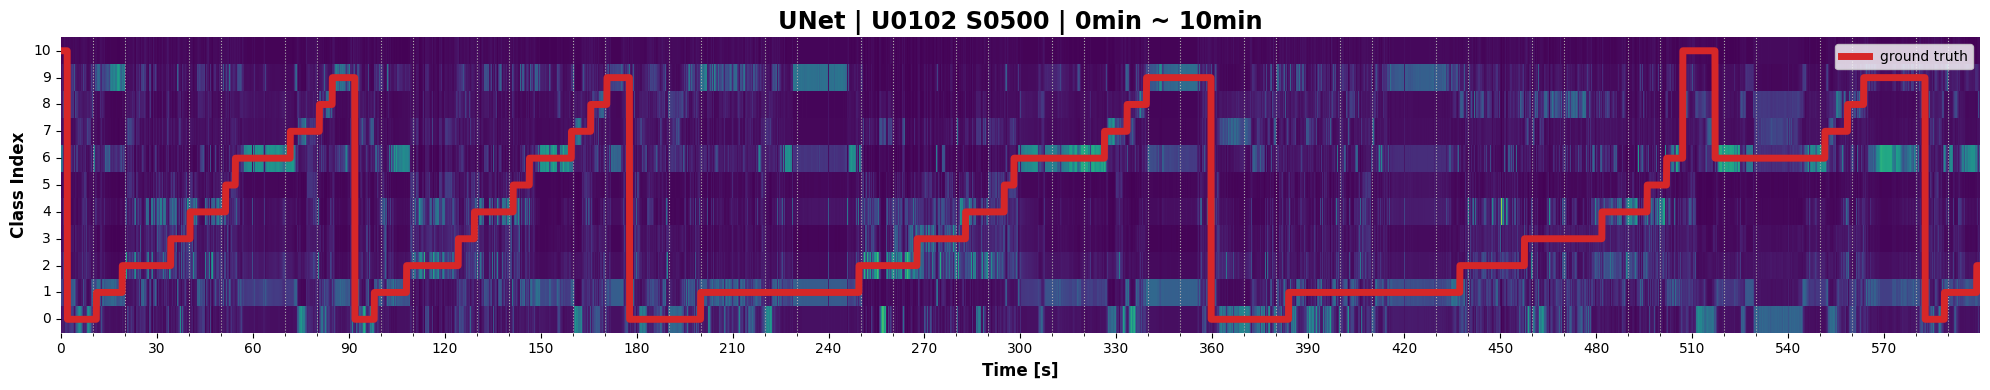

In [56]:
samples = (0, 10)

fig = plot_timeline(samples, t_idx, y_softmax, title_prefix=f"{cfg.model.name} | {user} {session}")
fig.show()

prob=(11, 18000) pred=(18000,), gt=(18000,)


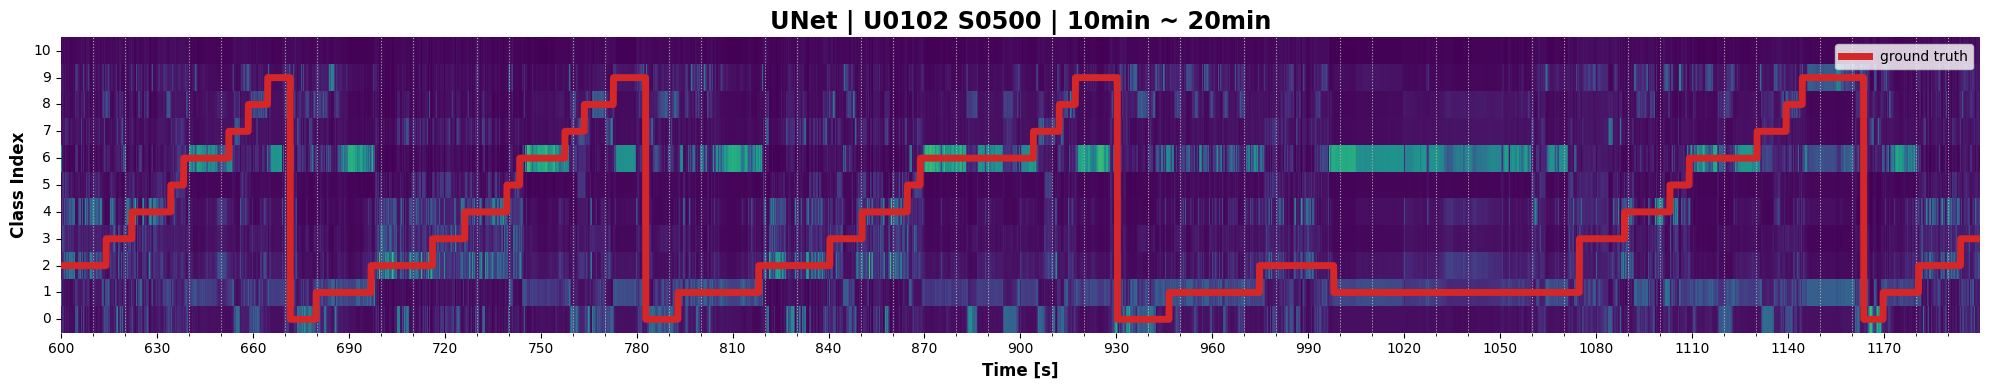

In [57]:
samples = (10, 20)

fig = plot_timeline(samples, t_idx, y_softmax, title_prefix=f"{cfg.model.name} | {user} {session}")
fig.show()

## [5] Submission

`optk.codalab.construct_submission_dict()` can be used to make submission files to codalab.
The parameter is almost the same as `optk.codalab.eval_operation_segmentation_wrapper()` (used for evaluation), but groundtruth field (`t_idx`) is exclided.

### 5-1: Get prediction for test data.

In [ ]:
cfg.mode = "submission"
datamodule.setup("submission")
dataloaders = datamodule.submission_dataloader()
split = cfg.dataset.split.submission

outputs = dict()
for i, dataloader in enumerate(dataloaders):
    user, session = split[i]
    logger.info(f"test on {user}-{session}")

    trainer.test(plmodel, dataloader)

    # save model outputs
    pred_dir = Path(
        cfg.path.logdir.predict.format(user=user, session=session)
    )
    pred_dir.mkdir(parents=True, exist_ok=True)

    for key, arr in plmodel.test_results.items():
        path = Path(pred_dir, f"{key}.npy")
        np.save(path, arr)
        logger.info(f"save {key}[shape={arr.shape}] to {path}")

    outputs[f"{user}-{session}"] = {
        "y": plmodel.test_results.get("y"),
        "unixtime": plmodel.test_results.get("unixtime"),
    }

### 5-2: Make submission zip file

In the `construct_submission_dict()`, following processing will be done.

- Convert a predcition tesor `y` (3D array of logits) into a sequence of predicted class ids.
- Resample sequence into 1 Hz.
- Exclude the segments that is out of range for the evaluation protocol (i.e., unlabeled or null segments).

In the `make_submission_zipfile()`, following processing will be done.

- extract `prediction` and `unixtime` field 
- generate `submission.json` and `submission.zip` to `output_dir`.

In [ ]:
output_dir = str(cfg.path.logdir.rootdir)

submission_dict = construct_submission_dict(outputs, ActSet(OPENPACK_OPERATIONS))
make_submission_zipfile(submission_dict, output_dir)

### 5-3: Submit to codalab and get results!

Now, you got a submission zip file (`./submission.zip`).
Let's upload it in the competition site (codalab) and get your score!

NOTE: If you are useing `optk.configs.datasets.splits.DEBUG_SPLIT` (default of this notebook), please use a submission form for "Development Phase".